**Curvature correction initialization**

In this notebook a 5-step procedure for curvature correction of an image is performed. The main idea of the curvature correction workflow is to work through a reference image and determine the procedure for correcting the curvature. Then the entire procedure (in form of different parameters) are stored in a config dictionaty (can also be printed to a file) which is later used to directly curvature correct future images with the same setup.


First, DarIA and pathlib's Path is imported.

In [1]:
import daria as da

from pathlib import Path

**Step 1: Initialization**

First the curved reference image (preferably with laser grid) is imported, here as a DarIA image. Then, the Python dictionary, that we will call config, is created where input parameters for the different parts of the curvature correction procedure will be stored.

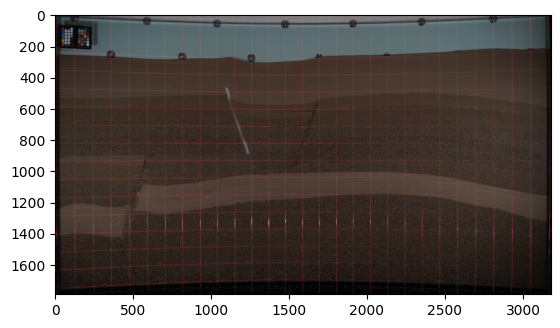

In [2]:
curved_image_gridded = da.Image(str(Path("../images/baseline_with_laser_grid.jpg")), width = 2.8, height = 1.5)
curved_image_gridded.plt_show()

config: dict() = {}

**Step 2: Pre-bulge correction**

The second step is to apply a pre-bulge correction. This is done to correcto for the camera's tendency to bulge vertical lines near the edges of the image outwards. Preferably, an as small as possible parameter should be chosen below such that all straight vertical lines either becomes straight or curves slightly inwards. 

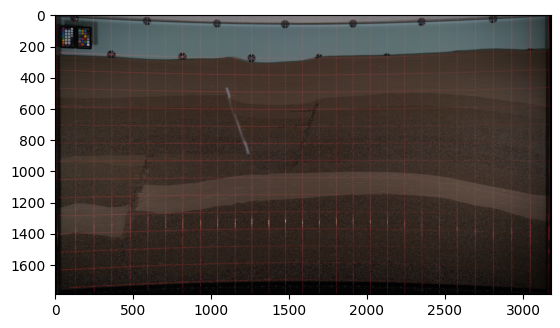

In [3]:
config["init"] = {
    "horizontal_bulge": 5e-9,
}

# Apply bulge 'correction'
curved_image_gridded.img = da.simple_curvature_correction(curved_image_gridded.img, **config["init"])

curved_image_gridded.plt_show()

**Step 3: Crop image**

Step 3 is to crop the image such that the corners of the FluidFlower appears in the corner of the image. The pixel values of the four corners of the FluidFlower should be provided, starting with the upper left corner and proceeding clockwise. The pixel values could be read by first plotting the image using the plt_show() method then mousing over the desired point. Then the crop function da.extract_quadrilateral_ROI() is applied.

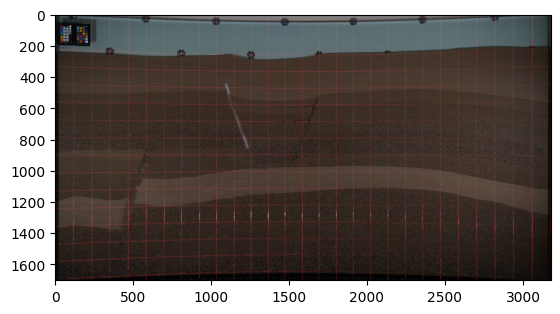

In [4]:
config["crop"] = {
    "pts_src": [
        [11, 8],
        [16, 1755],
        [3165, 1748],
        [3165, 5],
    ],
    # Specify the true dimensions of the reference points - known as they are points on the laser grid
    "width": 2.8,
    "height": 1.5,
    "in meters": True,
}

# Extract a quad ROI
curved_image_gridded.img = da.extract_quadrilateral_ROI(curved_image_gridded.img, **config["crop"])

curved_image_gridded.plt_show()

**Step 4: Bulge correction**

Step 4 is the actual bulge correction. Here, the number of pixels that the image curves inwards on each of the side should be provided. Then, the proper bulge-parameters are computed with the da.compute_bulge() function.

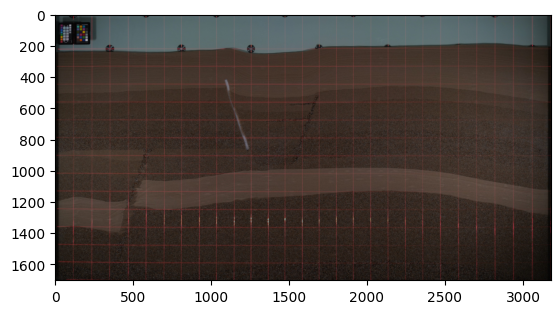

In [5]:
Ny, Nx = curved_image_gridded.img.shape[:2]

horizontal_bulge, horizontal_bulge_center_offset, vertical_bulge, vertical_bulge_center_offset = da.compute_bulge(Nx, Ny, left = 0, right = 0, top = 53, bottom = 57)

# Choose horizontal and vertical bulge such that all laser grid lines are bulged inwards
config["bulge"] = {
    "horizontal_bulge": horizontal_bulge,
    "horizontal_center_offset": horizontal_bulge_center_offset,
    "vertical_bulge": vertical_bulge,
    "vertical_center_offset": vertical_bulge_center_offset,
}

# Apply final curvature correction
curved_image_gridded.img = da.simple_curvature_correction(curved_image_gridded.img, **config["bulge"])
curved_image_gridded.plt_show()


**Step 5: Stretch**

The final modification is to correct for potential stretch in the image. To do this we need one point that has been stretched (point_src), the point that it has been stretched from (point_destination), and the stretch center (stretch_center). Then proper stretch parameters are computet with the da.compute_stretch() function.


In [6]:
horizontal_stretch, horizontal_stretch_center_offset, vertical_stretch, vertical_stretch_center_offset = da.compute_stretch(Nx, Ny, point_source = [585, 676], point_destination = [567, 676], stretch_center = [1476, 1020])

# Choose horizontal and vertical bulge such that all laser grid lines are bulged inwards
config["stretch"] = {
    "horizontal_stretch": horizontal_stretch,
    "horizontal_center_offset": horizontal_stretch_center_offset,
    "vertical_stretch": vertical_stretch,
    "vertical_center_offset": vertical_stretch_center_offset,
}

# Apply final curvature correction
curved_image_gridded.img = da.simple_curvature_correction(curved_image_gridded.img, **config["stretch"])
curved_image_gridded.plt_show()

**Closing thoughts and the config dictionary**

The main take-away message from this notebook should be the creation of the config dictionary

In [9]:
print(config)

{'init': {'horizontal_bulge': 5e-09}, 'crop': {'pts_src': [[11, 8], [16, 1755], [3165, 1748], [3165, 5]], 'width': 2.8, 'height': 1.5, 'in meters': True}, 'bulge': {'horizontal_bulge': -0.0, 'horizontal_center_offset': 0, 'vertical_bulge': -2.7332934272492954e-08, 'vertical_center_offset': -31}, 'stretch': {'horizontal_stretch': -1.3307656210674836e-08, 'horizontal_center_offset': -114, 'vertical_stretch': -0.0, 'vertical_center_offset': 169}}
